In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
#from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.cm as cm
import stat_plot as SP
import stattest as ST
import models as mdl
%load_ext autoreload
%autoreload 2


In [2]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")


In [3]:
# Convert the 'datetime' column to just the date (removes the time)
train_df['date'] = pd.to_datetime(train_df['date']).dt.date
test_df['date'] = pd.to_datetime(test_df['date']).dt.date

# Pivot the DataFrame
train_df = train_df.pivot(index='date', columns='symbol', values='close')
train_df.index = pd.to_datetime(train_df.index)
test_df = test_df.pivot(index='date', columns='symbol', values='close')
test_df.index = pd.to_datetime(test_df.index)

#interpolate the missing data (cause of CL1 and NG1 close time?)
train_df = train_df.interpolate(method='linear').bfill()
test_df= test_df.interpolate(method='linear').bfill()

#make data 
train_df = train_df.asfreq('B').ffill()
test_df= test_df.asfreq('B').ffill()


In [4]:
# Separate exogenous variables from the target columns
exog_train = train_df[['CL1', 'NG1']]
exog_test = test_df[['CL1', 'NG1']]

# Remove exogenous variables from train_df and test_df to avoid duplication
train_df = train_df.drop(columns=['CL1', 'NG1'])
test_df = test_df.drop(columns=['CL1', 'NG1'])


In [5]:
#Initial Model
order = (0, 1, 0)  # (p, d, q)
seasonal_order = (1, 1, 0, 21)  # (P, D, Q, m), where m is the seasonal period

# Fit the SARIMAX model
model_initial = SARIMAX(train_df['OXY'], order=order, seasonal_order=seasonal_order)
fitted_model_initial = model_initial.fit(disp=False)

# Print the model summary
print(fitted_model_initial.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                OXY   No. Observations:                 2837
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 21)   Log Likelihood               -5196.604
Date:                            Sat, 09 Nov 2024   AIC                          10397.207
Time:                                    14:11:04   BIC                          10409.093
Sample:                                11-26-2009   HQIC                         10401.496
                                     - 10-09-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L21      -0.5054      0.011    -47.840      0.000      -0.526      -0.485
sigma2         2.3443      0.034   

In [6]:
order = (1, 1, 0)  # (p, d, q)
seasonal_order = (2, 1, 0, 21)  # (P, D, Q, m), where m is the seasonal period

# Fit the SARIMAX model
model_opt = SARIMAX(train_df['OXY'], order=order, seasonal_order=seasonal_order)
fitted_model_opt = model_opt.fit(disp=False)

# Print the model summary
print(fitted_model_opt.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                OXY   No. Observations:                 2837
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 21)   Log Likelihood               -5045.106
Date:                            Sat, 09 Nov 2024   AIC                          10098.212
Time:                                    14:11:11   BIC                          10121.983
Sample:                                11-26-2009   HQIC                         10106.791
                                     - 10-09-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0450      0.014      3.157      0.002       0.017       0.073
ar.S.L21      -0.6677      0.014   

Ljung-Box Test Results:
    lb_stat  lb_pvalue
1  0.000722   0.978568
2  0.030559   0.984837
3  0.875761   0.831273
4  1.777081   0.776673
5  2.740916   0.739854


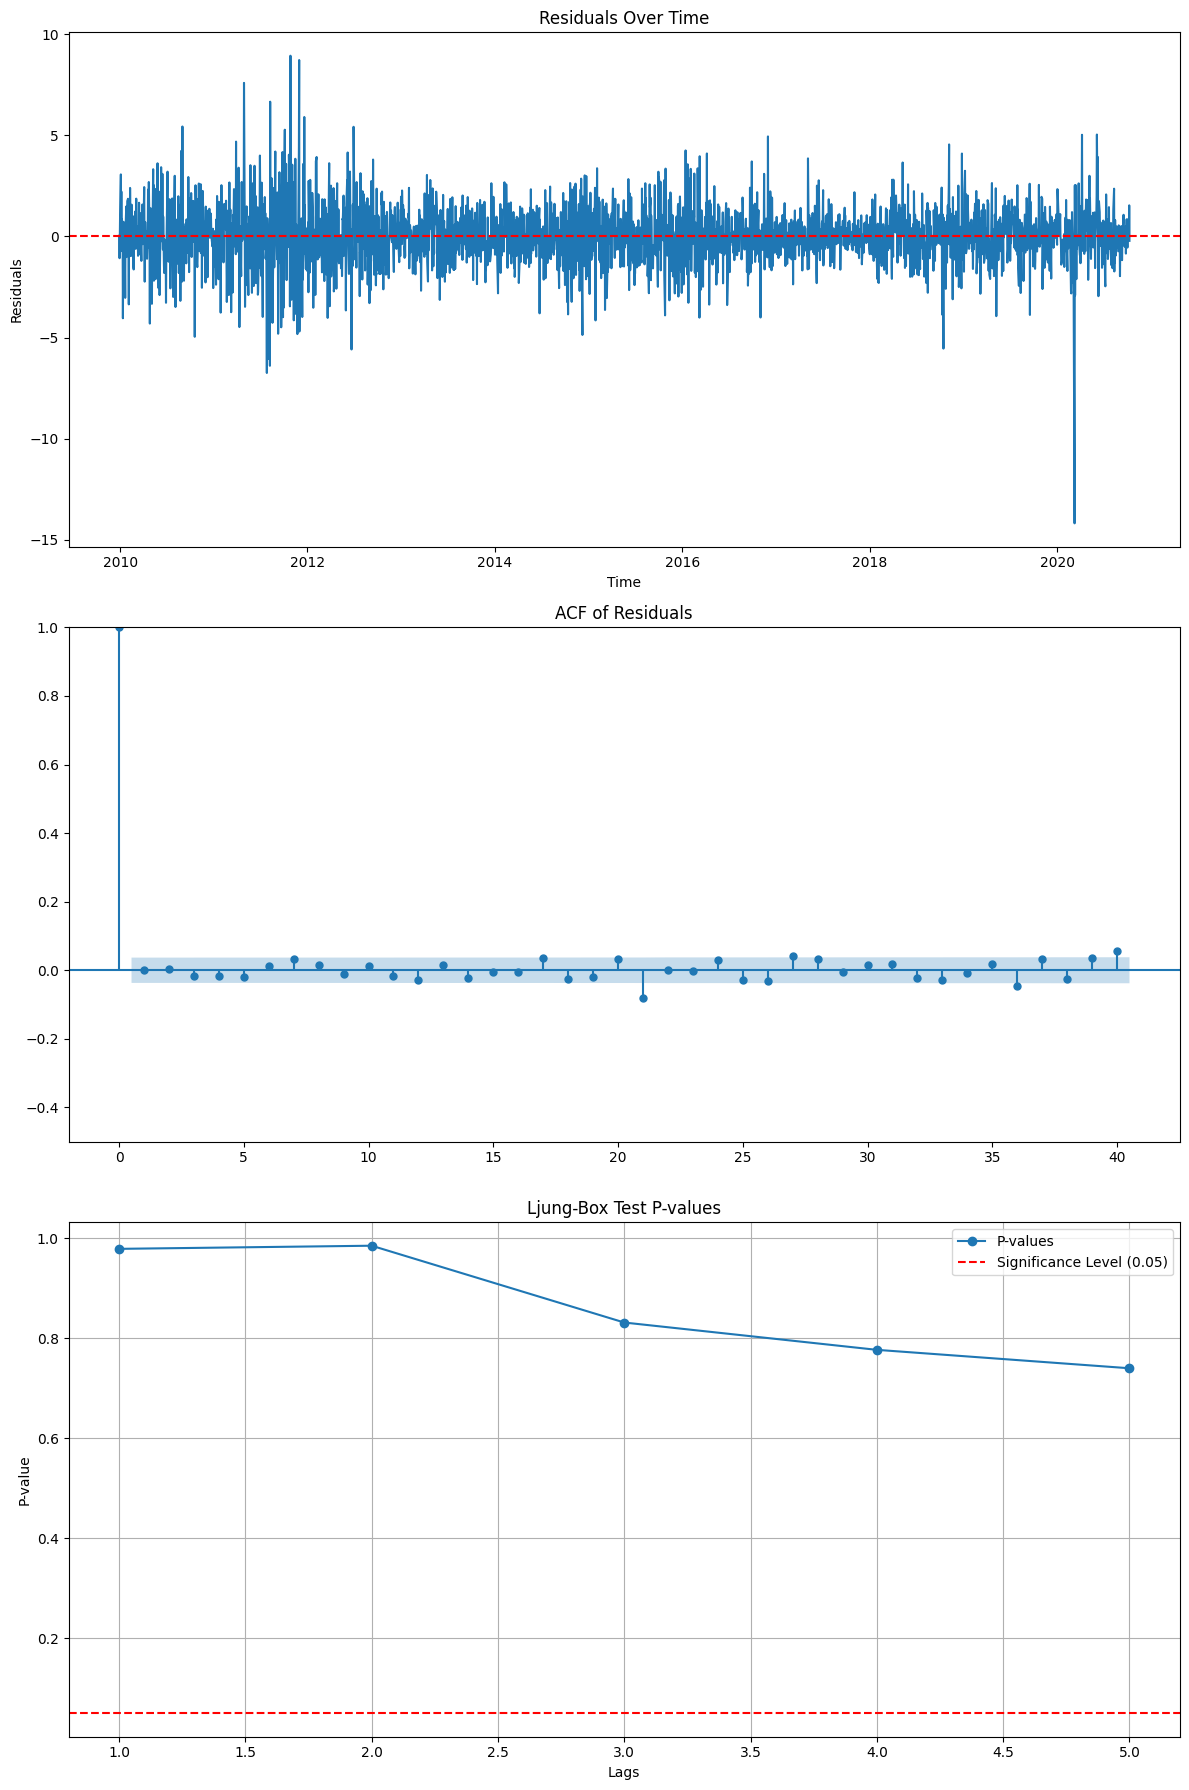

In [8]:
# Check residuals
residuals = fitted_model_opt.resid[22:] # Extract residuals

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# 1. Plot the residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

# 2. ACF plot of residuals
plot_acf(residuals, lags=40, ax=axs[1])
axs[1].set_title('ACF of Residuals')
axs[1].set_ylim(-0.5, 1)

# 3. Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[1,2,3,4,5], return_df=True)
print("Ljung-Box Test Results:")
print(lb_test)

# Plot Ljung-Box test p-values
axs[2].plot(lb_test.index, lb_test['lb_pvalue'], marker='o', linestyle='-', label='P-values')
axs[2].axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
axs[2].set_title('Ljung-Box Test P-values')
axs[2].set_xlabel('Lags')
axs[2].set_ylabel('P-value')
axs[2].grid(True)
axs[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:

sarima_model, results_dict = mdl.run_sarima(train_df[['OXY']], test_df[['OXY']], order=(1,1,0), seasonal_order=(2,1,0,21))

In [6]:
import pickle
# Save models and result_dict to files
with open('oxy_sarima_111_11121_model.pkl', 'wb') as models_file:
    pickle.dump(sarima_model, models_file)

with open('oxy_sarima_111_11121_result_dict.pkl', 'wb') as result_file:
    pickle.dump(results_dict, result_file)

print("Models and results have been saved.")

Models and results have been saved.


In [7]:
results_dict['OXY'].to_csv("OXY_SARIMA_111_11121.csv", index=True)